# Library

In [20]:
import requests
from bs4 import BeautifulSoup

import time
import datetime
from datetime import datetime, timedelta
import re

import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

art_project_path = '/content/drive/MyDrive/Art/Art_Project'
page_s = '/page_parsing_status.csv'
artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
theartnewspaper_d = '/theartnewspaper_data_new.csv'
artinvest_lt = '/artinvest_long_text.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'

In [2]:
#                          name    -            df             -         file (path)

df_dict = {'primary': {'artinvest': [['artinvest_news_articles_data', '/artinvest_news_articles_data.csv'],
                                     ['artinvest_long_text_df', '/artinvest_long_text.csv'],
                                     ['artinvest_pages_counter_stat', '/artinvest_pages_counter_stat.csv']
                                     ],
                       'theartnewspaper': [['theartnewspaper_data', '/theartnewspaper_data_new.csv'],
                                           ['theartnewspaper_long_text_df', '/theartnewspaper_long_text.csv']
                                           ],
                       'common': [['page_statistic', '/page_parsing_status.csv']]
                       },
           'combo': {'artinvest': ['artinvest_news_articles_w_text'],
                     'theartnewspaper': ['theartnewspaper_w_text'],
                     'common': []
                     }
           }

In [17]:
#for name, l in df_dict['primary'].items():
#  print(name, type(name))
#  for df in l[:2]:
#    print(df[0], type(df[0]), df[1], type(df[1]))

artinvest <class 'str'>
artinvest_news_articles_data <class 'str'> /artinvest_news_articles_data.csv <class 'str'>
artinvest_long_text_df <class 'str'> /artinvest_long_text.csv <class 'str'>
theartnewspaper <class 'str'>
theartnewspaper_data <class 'str'> /theartnewspaper_data_new.csv <class 'str'>
theartnewspaper_long_text_df <class 'str'> /theartnewspaper_long_text.csv <class 'str'>
common <class 'str'>
page_statistic <class 'str'> /page_parsing_status.csv <class 'str'>


In [7]:
#for name, l in df_dict['combo'].items():
#  print(name, type(name))
#  for df in l:
#    print(df, type(df))

artinvest <class 'str'>
artinvest_news_articles_w_text <class 'str'>
theartnewspaper <class 'str'>
theartnewspaper_w_text <class 'str'>
common <class 'str'>


## Sites' list for parsing

In [3]:
urls_news = ['https://artguide.com/', 'http://artuzel.com/', 'https://www.theartnewspaper.ru/']
# https://artguide.com/ - <div class="chromeframe">
#    Ваш браузер <em>устарел!</em> <a href="http://browsehappy.com/">Установите другой браузер</a> или
#    <a href="http://www.google.com/chromeframe/?redirect=true">Google Chrome Frame</a>, чтобы просматривать этот сайт.
urls_datasets = ['https://artchive.ru/', 'https://artinvestment.ru/']
urls_archives = ['https://russianartarchive.net/ru'] # есть API - https://api.raan.garagemca.org/documentation/#/
urls_fairs = ['https://www.cosmoscow.com/ru/']

# Unused code

In [59]:
#df_dict = {'artinvest': [artinvest_news_articles_data,
#                         artinvest_long_text_df,
#                         artinvest_news_articles_w_text,
#                         artinvest_pages_counter_stat
#                         ],
#           'theartnewspaper': [theartnewspaper_data,
#                               theartnewspaper_long_text_df,
#                               theartnewspaper_w_text
#                               ],
#           'common': [page_statistic]
#           }
#print(sys.getsizeof(df_dict))
#
#df_dict_ = {'artinvest': ['artinvest_news_articles_data',
#                         'artinvest_long_text_df',
#                         'artinvest_news_articles_w_text',
#                         'artinvest_pages_counter_stat'
#                         ],
#           'theartnewspaper': ['theartnewspaper_data',
#                               'theartnewspaper_long_text_df',
#                               'theartnewspaper_w_text'
#                               ],
#           'common': ['page_statistic']
#           }
#print(sys.getsizeof(df_dict_))

248
248


# Functions
correct:
- fix labels in some graphics

## Openings and savings
4. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
5. __open_file_csv(file)__ -> df - Open file.csv


13. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
14. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp


17. __save_df_file(df, file)__ -> - Save df to csv file

In [4]:
# 4. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 5.0 Open file.csv
def open_file_csv(file):
  df = pd.read_csv(art_project_path + file)
  return df

# 17. Save df to csv file
def save_df_file(df, file):
  df.to_csv(art_project_path + file, index=False)

In [5]:
# 13. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 14. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

## Data mining
1. __get_page(url)__ -> bs_page, page_parsing_status.csv - Collect request status


8. __get_artinvest_pages_counter_stat()__ -> - Parsing artinvest_pages_counter_stat ___and___ current artinvest_news_articles_data parsing ___and___ artinvest_long_text.csv
9. __get_artinvest_pages_curr_data(url)__ -> - Parsing current artinvest_news_articles_data
10. __get_artinvest_news_articles_archive()__ -> - Parsing artinvest_news_articles_data ARCHIVE
11. __def get_long_text()__ -> - Parsing long texts


15. __long_text_problems_fix()__ - Fixing long text problems


18. __date_transfomation(cell)__ -> cell - Date transfomation

In [21]:
# 1. Collect request status - saving every get result

def get_page(url):
  start_time = time.time()
  try:
    response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'}) # timeout=0.001
# Edge/97.0.1072.55
# Chrome/97.0.4692.71
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})

    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except HTTPError: # HTTPError: 503 Server Error: Service Temporarily Unavailable for url: https://artinvestment.ru/news/artnews/
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})
    
  finally:
    get_page_stat = open_file_csv(page_s) # 5.0 Open file.csv
    get_page_stat = pd.concat([get_page_stat, get_page_stat_new])

    save_df_file(get_page_stat, page_s) # 17. Save df to csv file

In [22]:
# 8. Parsing artinvest_pages_counter_stat and current artinvest_news_articles_data parsing

# 8.1 Get links list & # 8.2 Get titles list
def get_parsing_list(site, lable):
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  sites_list = [k for k in sites.keys()]
  cat_dict = ['news', 'articles'] # topping up list
  parsing_list = []

  for cat in cat_dict:
    for k in sites_list:
      if k==site:
        for i in sites[k]:
          if i==cat:
            parsing_list = list(parsing_list + sites[k][i][lable])
  
  return parsing_list

In [23]:
# 8.3 Parsing artinvest_pages_counter_stat - saving last parsing results from the first pages

def get_artinvest_pages_counter_stat(file):
  begining_p = time.time()
  parsing_speed_p = 0
  artinvest_pages_counter_stat = open_file_csv(file) # 5.0 Open file.csv
  # 18. Date transfomation
  artinvest_pages_counter_stat['parsing_date'] = artinvest_pages_counter_stat['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
  parsing_links_list = get_parsing_list('artinvestment.ru','links') # 8.1 Get links list
  parsing_titles_list = get_parsing_list('artinvestment.ru','titles') # 8.2 Get titles list

  parsing_speed_p = parsing_speed_p + (time.time() - begining_p)
  for link in parsing_links_list:
    link_page = get_page(link) # 1. Collect request status
    start_time = time.time()
    try: # never problems happen only None result
      table_blocks = link_page.find_all('div', class_='pager')
    except: continue
    else: # problems can start from here
      artinvest_pages_counter_stat_new = pd.DataFrame({'page_url': [link],
                                                       'page_title': [parsing_titles_list[parsing_links_list.index(link)]],
                                                       'records_total': [int(table_blocks[0].find_all('em')[0].text)],
                                                       'pages_total': [int(table_blocks[0].find_all('em')[1].text)],
                                                       'records_max': [int(table_blocks[0].find('input').get('title').split(' ')[1])],
                                                       'records_value': [int(table_blocks[0].find('input').get('value'))],
                                                       'first_page_url': [table_blocks[0].find('a').get('href')],
                                                       'parsing_date': [datetime.now().date()],
                                                       'parsing_time': [datetime.now().time()],
                                                       'parsing_sec_speed': [time.time() - start_time]
                                                       })
      artinvest_pages_counter_stat = pd.concat([artinvest_pages_counter_stat, artinvest_pages_counter_stat_new])
      parsing_speed_p = parsing_speed_p + (time.time() - start_time)
      
      # 9. Parsing current artinvest_news_articles_data
      get_artinvest_pages_curr_data(artinvest_d, link, link_page, parsing_titles_list, parsing_links_list)

  artinvest_pages_counter_stat.drop_duplicates(subset = ['page_url', 'parsing_date'], keep = 'last', inplace = True)
  new_pages_count = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()]['page_url'].count()

  save_df_file(artinvest_pages_counter_stat, file) # 17. Save df to csv file

  return print('{} new pages have been collected\nin {} seconds\nAll pages have been collected - {}'.format(new_pages_count, parsing_speed_p, (new_pages_count==len(parsing_links_list))))

In [24]:
# 9. Parsing current artinvest_news_articles_data - saving last parsing results from the first pages

def get_artinvest_pages_curr_data(file, page_url, page, parsing_titles, parsing_links):
  begining_a = time.time()
  parsing_speed_a = 0
  artinvest_news_articles_data = open_file_csv(file) # 5.0 Open file.csv
  # 18. Date transfomation
  artinvest_news_articles_data['parsing_date'] = artinvest_news_articles_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x))

  try: # never problems happen only None result
    start_time = time.time()
    list_advices = page.find_all('ul', class_='list advices')
  except: pass
  else: # problems can start from here
    dates_list = []
    for em in list_advices[0].find_all('em'):
      dates_list.append(em.text)
    links_list = []
    titles_list = []
    for a in list_advices[0].find_all('a'):
      if re.compile('\d+').search(str(a.get('href')))is not None:
        links_list.append(a.get('href'))
      if a.get('title') is not None:
        titles_list.append(a.get('title'))
    short_text_list = []
    for span in list_advices[0].find_all('span')[1::2]:
      short_text_list.append(span.text)

    artinvest_news_articles_data_new = pd.DataFrame({'date': dates_list,
                                                     'link': links_list,
                                                     'title': titles_list,
                                                     'short_text': short_text_list,
                                                    })
    artinvest_news_articles_data_new['page_url'] = page_url
    artinvest_news_articles_data_new['page_title'] = parsing_titles[parsing_links.index(page_url)]
    artinvest_news_articles_data_new['parsing_date'] = datetime.now().date()
    artinvest_news_articles_data_new['parsing_time'] = datetime.now().time()
    artinvest_news_articles_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

    # For parsing long texts
    artinvest_news_articles_data_new['long_text_url'] = artinvest_news_articles_data_new['page_url'] + artinvest_news_articles_data_new['link']
    long_text_url_list_new = artinvest_news_articles_data_new['long_text_url'].tolist()
    long_text_url_list = artinvest_news_articles_data['long_text_url'].tolist()
    long_text_url_list_temp = list(set(long_text_url_list_new) - set(long_text_url_list)) # only new urls - temporal list
    save_long_text_url_list_temp(long_text_url_list_temp) # 14. Save json long_text_url_list_temp

    collected_pages_a_count = artinvest_news_articles_data_new['page_url'].count()
    artinvest_news_articles_data = pd.concat([artinvest_news_articles_data, artinvest_news_articles_data_new])
    artinvest_news_articles_data.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
    parsing_speed_a = parsing_speed_a + (time.time() - begining_a)
    
    save_df_file(artinvest_news_articles_data, file) # 17. Save df to csv file

    time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
    get_long_text(artinvest_lt) # 11. Parsing long texts

    return print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, parsing_speed_a))

In [25]:
# 11. Parsing long texts - saving only new results from the first pages
    
def get_long_text(file):
  begining_t = time.time()
  parsing_speed_t = 0
  artinvest_long_text_df = open_file_csv(file) # 5.0 Open file.csv
  long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      text_block = text_page.find('div', class_='block content-data article-content')
      text_all = text_block.find_all('p')
      text_list = []
      for p in text_all:
        text_list.append(p.text)
      long_text_list.append(text_list)
    except: 
      text_list = []
      long_text_list.append(text_list)
    try:
      sourse_all = text_block.find('p', class_='mat2left').find_all('a')
      sourses = []
      for a in sourse_all:
        sourses.append(a.get('href'))
      sourses_list.append(sourses)
    except: 
      sourses = []
      sourses_list.append(sourses)
    finally:
      parsing_speed_list.append(time.time() - start_time)

  artinvest_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                             'long_text': long_text_list,
                                             'sourses': sourses_list,
                                             'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                            })
  
  collected_pages_t_count = artinvest_long_text_df_new['long_text_url'].count()
  artinvest_long_text_df = pd.concat([artinvest_long_text_df, artinvest_long_text_df_new])
  artinvest_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  save_df_file(artinvest_long_text_df, file) # 17. Save df to csv file

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

# 11.1 Parsing problematic long texts

def get_long_text_problems(file, long_text_url_list):
  begining_t = time.time()
  parsing_speed_t = 0
  artinvest_long_text_df = open_long_text(file) # 12. Open long_text.csv
    
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      text_block = text_page.find('div', class_='block content-data article-content')
      text_all = text_block.find_all('p')
      text_list = []
      for p in text_all:
        text_list.append(p.text)
      long_text_list.append(text_list)
    except: 
      text_list = []
      long_text_list.append(text_list)
    try:
      sourse_all = text_block.find('p', class_='mat2left').find_all('a')
      sourses = []
      for a in sourse_all:
        sourses.append(a.get('href'))
      sourses_list.append(sourses)
    except: 
      sourses = []
      sourses_list.append(sourses)
    finally:
      parsing_speed_list.append(time.time() - start_time)

  artinvest_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                             'long_text': long_text_list,
                                             'sourses': sourses_list,
                                             'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                            })

  collected_pages_t_count = artinvest_long_text_df_new['long_text_url'].count()
  artinvest_long_text_df = pd.concat([artinvest_long_text_df, artinvest_long_text_df_new])
  artinvest_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  save_df_file(artinvest_long_text_df, file) # 17. Save df to csv file

  return print('{} text pages have been collected\nin {} seconds\nAll pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

In [26]:
# 15. Fixing long text problems
def long_text_problems_fix(name, df):
  cheking_long_text_list = []
  for url in df.loc[df['long_text'].isna()==True]['long_text_url']:
    cheking_long_text_list.append(url)

  delta = len(cheking_long_text_list)

  if delta == 0:
    df['long_text_len'] = df['long_text'].apply(lambda x: len(x[1:-1]))
    cheking_long_text_list = []
    for url in df.loc[df['long_text_len']==0]['long_text_url']:
      cheking_long_text_list.append(url)

    delta = len(cheking_long_text_list)
    df = df.drop(['long_text_len'], axis=1)

    if delta == 0:
      result = 'All long texts were found'
    else:
      long_text_url_visited = len(page_statistic.loc[page_statistic['page_url'].isin(cheking_long_text_list)]['page_url'].unique().tolist())
      long_text_url_list = cheking_long_text_list
      
      #for k in combo_df_dict.keys():
      if name=='artinvest':
        get_long_text_problems(artinvest_lt, long_text_url_list) # 11.1 Parsing problematic long texts
      elif name=='theartnewspaper':
        get_theartnewspaper_problems_long_text(theartnewspaper_lt, long_text_url_list) # Parsing problematic long texts
      
      result = 'Long texts delta is - {}\nCount of sites were visited - {}'.format(delta, long_text_url_visited)
  
  return print(result)

In [27]:
# 10. Parsing artinvest_news_articles_data ARCHIVE

def get_artinvest_news_articles_archive(file, p_url):
  artinvest_pages_counter_stat_arch = open_file_csv(file) # 5.0 Open file.csv
  # 18. Date transfomation
  artinvest_pages_counter_stat_arch['parsing_date'] = artinvest_pages_counter_stat_arch['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
  artinvest_pages_counter_stat_arch = artinvest_pages_counter_stat_arch.loc[(artinvest_pages_counter_stat_arch['page_url']==p_url)&(artinvest_pages_counter_stat_arch['parsing_date']==artinvest_pages_counter_stat_arch['parsing_date'].max())]

  # For parsing current artinvest_news_articles_data
  pars_links_list = artinvest_pages_counter_stat_arch['page_url'].tolist()
  pars_titles_list = artinvest_pages_counter_stat_arch['page_title'].tolist()
  # For next_page_url_list
  first_page_url_list = artinvest_pages_counter_stat_arch['first_page_url'].tolist()
  pages_total_list = artinvest_pages_counter_stat_arch['pages_total'].tolist()

  next_page_url_list = []
  for url in first_page_url_list:
    pages_total = pages_total_list[first_page_url_list.index(url)]
    url_part_1 = url.split('=')[0]
    url_part_2 = url.split('=')[1].split('&')[1]
    url_part_3 = url.split('=')[2]

    for p in range(2,pages_total+1):
      next_page_url = url_part_1 + '=' + str(p) + '&' + url_part_2 + '=' + url_part_3
      next_page_url_list.append(next_page_url)

  for p_url in next_page_url_list:
    page = get_page(p_url) # 1. Collect request status
    # 9. Parsing current artinvest_news_articles_data
    get_artinvest_pages_curr_data(artinvest_d, p_url.split('=')[0][:-5], page, pars_titles_list, pars_links_list)

In [28]:
# 18. Date transfomation
def date_transfomation(cell):
  try:
    cell = pd.to_datetime(datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')).date()
  except ValueError:
    cell = pd.to_datetime(cell).date()
  return cell

## Graphics
16. get_graphics() -> - Drawing graphics

In [29]:
# 16. Drawing graphics
def get_stat_graphics():
  # 16.1 Checking responses status
  print('Checking responses status & Parsing date')
  print('')
  new_stat = page_statistic.loc[page_statistic['parsing_date'] >= (page_statistic['parsing_date'].max() + timedelta(days = -7))]
  
  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  
  axes[0].hist(page_statistic['status_code'])
  axes[0].set_title('Status code')
  axes[0].set_ylabel('Count')
  #axes[0].set_xticklabels(page_statistic['status_code'].unique(), rotation = 45)
  
  axes[1].hist(new_stat['parsing_date'])
  axes[1].set_title('Parsing date counts')
  axes[1].set_ylabel('Count')
  axes[1].set_xticklabels(new_stat['parsing_date'].unique(), rotation = 45)

  plt.show()

  # 16.2 Collecting Pages counter mining avarege speed
  print('')
  print('Collecting Pages counter mining avarege speed')
  print('')
  grouped_page_stat = page_statistic.groupby(['parsing_date', 'page_url'])['parsing_sec_speed'].agg(['mean']).reset_index()

  pages_counter_mining = pd.merge(artinvest_pages_counter_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_counter_mining.columns = ['page_url', 'page_title', 'records_total', 'pages_total', 'records_max', 'records_value',
                                  'first_page_url', 'parsing_date', 'parsing_time', 'parsing_counter_speed', 'parsing_page_speed']
  pages_counter_mining['parsing_speed_total'] = pages_counter_mining['parsing_counter_speed'] + pages_counter_mining['parsing_page_speed']

  pages_counter_mining = pages_counter_mining.loc[pages_counter_mining['parsing_date'] >= (pages_counter_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_counter_mining = pages_counter_mining.groupby(['parsing_date'])[['parsing_speed_total', 'parsing_page_speed', 'parsing_counter_speed']].mean().reset_index()

  fig, axes = plt.subplots(1, 3, figsize=(12,4))
  axes[0].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_counter_speed'], color='green')
  axes[2].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Counter avg speed in seconds')

  plt.show()

  # 16.3 Collecting Data mining avarege speed
  print('')
  print('Collecting Data mining avarege speed')
  print('')
  grouped_news_articl_stat = artinvest_news_articles_w_text.groupby(['parsing_date', 'page_url'])['parsing_sec_speed', 'parsing_sec_speed_2'].agg(['mean']).reset_index()
  grouped_news_articl_stat.columns = ['parsing_date',	'page_url',	'parsing_data_speed',	'parsing_text_speed']

  pages_data_mining = pd.merge(grouped_news_articl_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_data_mining.columns = ['parsing_date', 'page_url', 'parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed']

  pages_data_mining['parsing_speed_total'] = pages_data_mining['parsing_data_speed'] + pages_data_mining['parsing_text_speed'] + pages_data_mining['parsing_page_speed']

  pages_data_mining = pages_data_mining.loc[pages_data_mining['parsing_date'] >= (pages_data_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_data_mining = pages_data_mining.groupby(['parsing_date'])[['parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed', 'parsing_speed_total']].mean().reset_index()

  fig, axes = plt.subplots(1, 4, figsize=(12,4))
  axes[0].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_data_speed'], color='green')
  axes[2].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Data avg speed in seconds')

  axes[3].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_text_speed'], color='orange')
  axes[3].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[3].set_title('Text avg speed in seconds')

  plt.show()

In [30]:
# 16.4 Articles counting
def get_articles_graphic(df):
  # today for previouse day or for some days ago
  new_data = df.loc[df['date']>=df['parsing_date'].unique()[1]]

  print('Articles counting')
  print('')
  
  fig = plt.figure()
  axes = fig.add_axes([0,0,1,1])
  axes.hist(new_data['page_title'])
  axes.set_title('New articles')
  axes.set_ylabel('Count')
  axes.set_xticklabels(new_data['page_title'].unique(), rotation = 20)

  plt.show()

  print('')
  print('New articles titles:')
  print('')
  for t in new_data['title']:
    print(t)

# Sites parsing: news and articles only

## artinvestment.ru

In [ ]:
# Parsing artinvest_pages_counter_stat and current artinvest_news_articles_data parsing
start_t = time.time()
get_artinvest_pages_counter_stat(artinvest_s) # 8.3 Parsing artinvest_pages_counter_stat
finish_t = time.time() - start_t
print('{} seconds have passed'.format(finish_t))

0 text pages have been collected
in 3.7280514240264893 seconds
All text pages have been collected - True
30 articles have been collected
in 2.192906141281128 seconds
3 text pages have been collected
in 4.9611735343933105 seconds
All text pages have been collected - True
30 articles have been collected
in 1.677344799041748 seconds
1 text pages have been collected
in 2.756591558456421 seconds
All text pages have been collected - True
30 articles have been collected
in 1.6018085479736328 seconds
0 text pages have been collected
in 1.7373428344726562 seconds
All text pages have been collected - True
30 articles have been collected
in 1.6767005920410156 seconds
0 text pages have been collected
in 1.8036856651306152 seconds
All text pages have been collected - True
30 articles have been collected
in 1.6182937622070312 seconds
0 text pages have been collected
in 1.7214815616607666 seconds
All text pages have been collected - True
30 articles have been collected
in 1.571474552154541 seconds
0 

In [ ]:
# !!! do it just once
# Parsing artinvest_news_articles_data ARCHIVE

confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_artinvest_news_articles_archive(artinvest_s) # 10. Parsing artinvest_news_articles_data ARCHIVE
else:
  print('Nothing has happened')

# done !!!

Confirm the archive parsing (y/n)n
Nothing has happened


## theartnewspaper.ru
- news duplicates - same news in different categories - saving just one (long_text_url) - what category? - is it important?

In [ ]:
# Parsing current theartnewspaper_data

def get_theartnewspaper_pages_curr_data(file, url):
  begining_a = time.time()
  #parsing_speed_a = 0
  theartnewspaper_data = open_file_csv(file) # 5.0 Open file.csv
  theartnewspaper_data['parsing_date'] = theartnewspaper_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x))

  parsing_links_list = get_parsing_list('theartnewspaper.ru','links') # 8.1 Get links list
  parsing_titles_list = get_parsing_list('theartnewspaper.ru','titles') # 8.2 Get titles list

  collected_pages_a_count = 0
  for link in parsing_links_list:
    news_page = get_page(link) # 1. Collect request status

    links_list = []
    titles_list = []
    dates_list = []
    page_title_list = []
    short_text_list = []
    page_url_list = []

    start_time = time.time()
    for prenews in news_page.find_all('div', class_='postPreviewsV2Root js-fix-post-previews'):
      for a in prenews.find_all('a'):
        links_list.append(a.get('href'))
        titles_list.append(a.get('title'))
    for date in news_page.find_all('div', class_='postPreviewsItemDate'):
      dates_list.append(date.get_text())
    for p_title in news_page.find_all('div', class_='postPreviewsItemSection'):
      page_title_list.append(p_title.get_text())
      page_url_list.append(link)
    for s_text in news_page.find_all('div', class_='postPreviewsItemTitle2 js-fix-hanging js-icon-read-more'):
      short_text_list.append(s_text.get_text())

    theartnewspaper_data_new = pd.DataFrame({'date': dates_list,
                                             'link': links_list,
                                             'title': titles_list,
                                             'short_text': short_text_list,
                                             'page_url': page_url_list,
                                             'page_title': page_title_list
                                             })
    theartnewspaper_data_new['page_url'] = theartnewspaper_data_new['page_url'].apply(lambda x: x[:-1])
    theartnewspaper_data_new['parsing_date'] = datetime.now().date()
    theartnewspaper_data_new['parsing_time'] = datetime.now().time()
    theartnewspaper_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

    # For parsing long texts
    theartnewspaper_data_new['long_text_url'] = url[:-1] + theartnewspaper_data_new['link']
    long_text_url_list_new = theartnewspaper_data_new['long_text_url'].tolist()
    long_text_url_list = theartnewspaper_data['long_text_url'].tolist()
    long_text_url_list_temp = list(set(long_text_url_list_new) - set(long_text_url_list)) # only new urls - temporal list
    save_long_text_url_list_temp(long_text_url_list_temp) # 14. Save json artinvest_long_text_url_list_temp

    collected_pages_a_count += theartnewspaper_data_new['page_url'].count()
    theartnewspaper_data = pd.concat([theartnewspaper_data, theartnewspaper_data_new])
    theartnewspaper_data.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
    #parsing_speed_a += (time.time() - begining_a)

    time.sleep(5) # time for renewing json long_text_url_list_temp
    get_theartnewspaper_long_text(theartnewspaper_lt) # 11. Parsing long texts

  parsing_speed_a = time.time() - begining_a # including getting long text
  #theartnewspaper_data.to_csv(art_project_path + '/theartnewspaper_data_new.csv', index=False)
  save_df_file(theartnewspaper_data, file)

  return print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, parsing_speed_a))

In [ ]:
# Parsing long texts - saving only new results from the first pages
    
def get_theartnewspaper_long_text(file):
  begining_t = time.time()
  parsing_speed_t = 0
  theartnewspaper_long_text_df = open_file_csv(file) # 5.0 Open file.csv
  long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []
  add_info_list = []
  autors_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      add_info = [text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get('href'),
                  text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get_text()
                  ]
    except:
      add_info = []
    add_info_list.append(add_info)
  
    autors_l = []
    for a in text_page.find_all('a', class_='postAuthorsItem'):
      autors_l.append(a.get_text())
    autors = ', '.join(autors_l)
    autors_list.append(autors)

    long_text = []
    for lc in text_page.find_all('div', class_='leftCol630'):
      long_text.append(lc.get_text())
    long_text_list.append(long_text)

    sourses_list.append([])
    parsing_speed_list.append(time.time() - start_time)

  theartnewspaper_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                                   'long_text': long_text_list,
                                                   'sourses': sourses_list,
                                                   'parsing_sec_speed_2': parsing_speed_list, # for long_text collection without getting page
                                                   'autors': autors_list,
                                                   'add_info': add_info_list
                                                   })
  
  collected_pages_t_count = theartnewspaper_long_text_df_new['long_text_url'].count()
  theartnewspaper_long_text_df = pd.concat([theartnewspaper_long_text_df, theartnewspaper_long_text_df_new])
  theartnewspaper_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t += (time.time() - begining_t)

  #theartnewspaper_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(theartnewspaper_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

# Parsing long texts - saving only new results from the first pages
    
def get_theartnewspaper_problems_long_text(file, long_text_url_list):
  begining_t = time.time()
  parsing_speed_t = 0
  theartnewspaper_long_text_df = open_long_text(file) # 12. Open long_text.csv
  #long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []
  add_info_list = []
  autors_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      add_info = [text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get('href'),
                  text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get_text()
                  ]
    except:
      add_info = []
    add_info_list.append(add_info)
  
    autors_l = []
    for a in text_page.find_all('a', class_='postAuthorsItem'):
      autors_l.append(a.get_text())
    autors = ', '.join(autors_l)
    autors_list.append(autors)

    long_text = []
    for lc in text_page.find_all('div', class_='leftCol630'):
      long_text.append(lc.get_text())
    long_text_list.append(long_text)

    sourses_list.append([])
    parsing_speed_list.append(time.time() - start_time)

  theartnewspaper_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                                   'long_text': long_text_list,
                                                   'sourses': sourses_list,
                                                   'parsing_sec_speed_2': parsing_speed_list, # for long_text collection without getting page
                                                   'autors': autors_list,
                                                   'add_info': add_info_list
                                                   })
  
  collected_pages_t_count = theartnewspaper_long_text_df_new['long_text_url'].count()
  theartnewspaper_long_text_df = pd.concat([theartnewspaper_long_text_df, theartnewspaper_long_text_df_new])
  theartnewspaper_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t += (time.time() - begining_t)

  #theartnewspaper_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(theartnewspaper_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

In [ ]:
# Parsing
start_t = time.time()
url_tanp = urls_news[2]
get_theartnewspaper_pages_curr_data(theartnewspaper_d, url_tanp)
finish_t = time.time() - start_t
print('{} seconds have passed'.format(finish_t))

0 text pages have been collected
in 0.027233123779296875 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.015889644622802734 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.017333030700683594 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.014642477035522461 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.014323949813842773 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.01736927032470703 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.015170574188232422 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.01444697380065918 seconds
All text pages have been collected - True
145 articles have been collected
in 49.21728539466858 seconds
49.22726774215698 seconds have passed


# Checking

## Preprocessing

In [26]:
# Opening
opened_df_dict = {}
for name, l in df_dict['primary'].items():
  for df in l:
    print('{} file is opened'.format(df[0]))
    name = df[0]
    new_df = open_file_csv(df[1]) # 5.0 Open file.csv
    opened_df_dict.update({name: new_df})
print('{} files were opened'.format(len(opened_df_dict)))

artinvest_news_articles_data file is opened
artinvest_long_text_df file is opened
artinvest_pages_counter_stat file is opened
theartnewspaper_data file is opened
theartnewspaper_long_text_df file is opened
page_statistic file is opened
6 files were opened


In [27]:
# Dates transformation and sorting
for name, df in opened_df_dict.items():
  # transformation
  try:
    df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 18. Date transfomation
    df.sort_values(by=['parsing_date'], inplace=True, ascending=False)
  except: continue
  # sorting
  try:
    df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 18. Date transfomation
  except: continue

In [28]:
for d in opened_df_dict['artinvest_news_articles_data']['date'][:5]:
  print(type(d))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [33]:
# Data and long text df-s combining
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')

# topping up dict (manually yet)
combo_df_dict = {'artinvest': artinvest_news_articles_w_text,
                 'theartnewspaper': theartnewspaper_w_text
                 }

## Checking data fullfillness

In [44]:
# Checking long texts
for name, df in combo_df_dict.items():
  print(name)
  long_text_problems_fix(name, df) # 15. Fixing long text problems

artinvest
23 text pages have been collected
in 37.671326637268066 seconds
All pages have been collected - True
Long texts delta is - 23
Count of sites were visited - 23
theartnewspaper
All long texts were found


In [ ]:
# Checking artinvest collected lines

pages_counter = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()][['page_url', 'page_title', 'records_total']]
data_counter = artinvest_news_articles_data.groupby(['page_title']).size().to_frame(name = 'count').reset_index()
combo = pages_counter.merge(data_counter, on='page_title', how='outer')
combo['delta'] = combo['records_total'] - combo['count']

problem_archive_pages = combo.loc[combo['delta']!=0]['page_url'].tolist()
if len(problem_archive_pages)==0:
  print('Records delta has not found')
else:
  display(combo.loc[combo['page_url'].isin(problem_archive_pages)])

Records delta has not found


In [ ]:
# Parsing artinvest_news_articles_data ARCHIVE again
# !!!
confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_artinvest_news_articles_archive(problem_archive_pages[0]) # 10. Parsing artinvest_news_articles_data ARCHIVE
else:
  print('Nothing has happened')

Confirm the archive parsing (y/n)n
Nothing has happened


## Graphics

Checking responses status & Parsing date



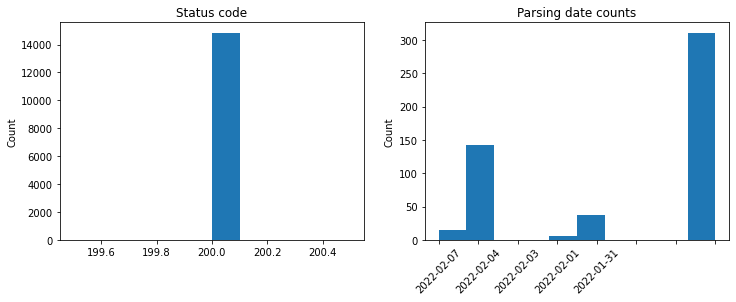

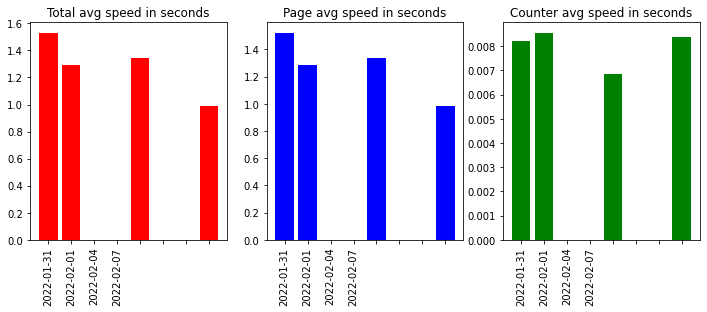

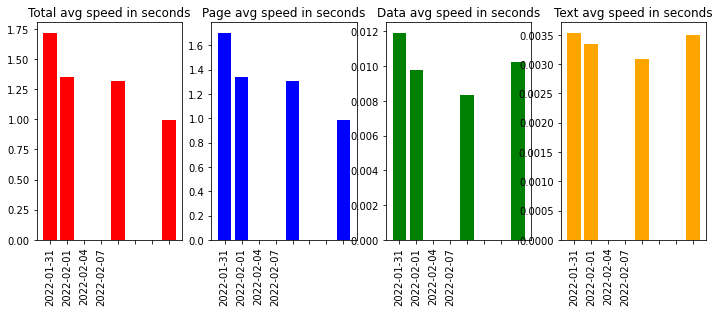

In [30]:
get_stat_graphics() # 16. Drawing graphics


artinvest

Articles counting



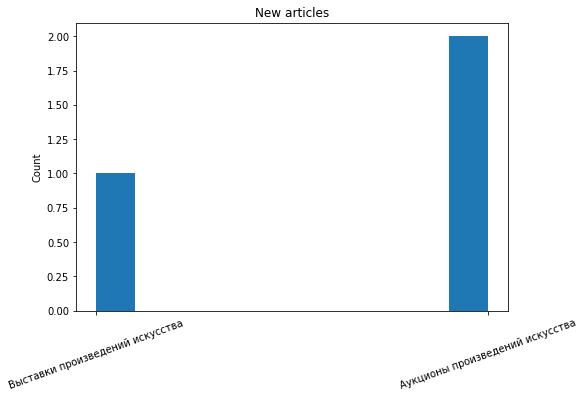


New articles titles:

Новая выставка портретов Ван Гога показывает историю изменения его психического здоровья
Итоги AI аукциона № 415
Владельцы «Талисмана Наполеона» надеются продать его за $250 млн

theartnewspaper

Articles counting



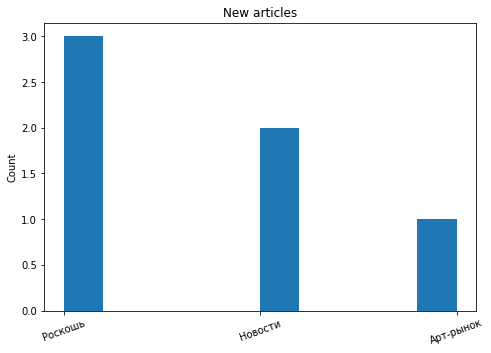


New articles titles:

Русские сюжеты
Высокое чувство
Связанные одной сеткой
Возбуждено уголовное дело из-за порчи картины Анны Лепорской
Свежий номер: музеи открываются, мумии возвращаются
Прогнозы на 2022-й: международный арт-рынок ждут изменения


In [46]:
for name, df in combo_df_dict.items():
  print('')
  print(name)
  print('')
  get_articles_graphic(df) # 16.4 Articles counting

## df info

In [12]:
for name, df in opened_df_dict.items():
  print(name)
  print('')
  df.info()
  print('')

artinvest_news_articles_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12984 entries, 0 to 12983
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               12984 non-null  object 
 1   link               12984 non-null  object 
 2   title              12984 non-null  object 
 3   short_text         12984 non-null  object 
 4   page_url           12984 non-null  object 
 5   page_title         12984 non-null  object 
 6   parsing_date       12984 non-null  object 
 7   parsing_time       12984 non-null  object 
 8   parsing_sec_speed  12984 non-null  float64
 9   long_text_url      12984 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1014.5+ KB

artinvest_long_text_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12984 entries, 0 to 12983
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----

In [17]:
index = 0
for name, df in opened_df_dict.items():
  print(name, index)
  print('')
  index += 1

artinvest_news_articles_data 0

artinvest_long_text_df 1

artinvest_pages_counter_stat 2

theartnewspaper_data 3

theartnewspaper_long_text_df 4

page_statistic 5



In [19]:
opened_df_dict['artinvest_news_articles_data'].head()

,date,link,title,short_text,page_url,page_title,parsing_date,parsing_time,parsing_sec_speed,long_text_url
0,08.12.2021,20211208_Aphrodite_sale.html,"Римская скульптура Афродиты продана за $24,6 млн",Это новый рекорд цены на античную мраморную ск...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211208...
1,07.12.2021,20211207_Pak_The_Merge_Sale.html,"NFT-проект цифрового художника Pak принес $91,...",Результат распродажи токенов из проекта The Me...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211207...
2,06.12.2021,20211206_GES2_opening.html,В Москве открыли новое культурное пространство...,Дом культуры «ГЭС-2» открылся в эту субботу в ...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211206...
3,25.11.2021,20211125_Elisium_Antique_salon.html,Галерея «Элизиум» приглашает посетить свой сте...,В Гостином дворе до 28 ноября открыт 47-й Росс...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211125...
4,24.11.2021,20211124_Art_Wars_NFT.html,Вокруг токенов по мотивам «Звездных войн» разы...,Группа современных художников намерена судитьс...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211124...


## artinvestment.ru

In [ ]:
artinvest_long_text_df['long_text'][0]

"['Вчера, 7 декабря 2021,  аукционный дом Sotheby’s провел в своем лондонском офисе  торги одного лота — римской мраморной скульптуры богини Афродиты, известной как  Афродита Гамильтона (по имени одного из владельцев). Лот был выставлен с  оценкой £2–3 млн, но в ходе 20-минутной аукционной борьбы между пятью  претендентами скульптура превысила эстимейт как минимум в девять раз. Новому  владельцу — некому азиатскому клиенту Sotheby’s,  чьи ставки называла менеджер по работе с клиентами Николь Чинг — Афродита  Гамильтона досталась за £18,6 млн ($24,6 млн) с учетом комиссии аукционного  дома. Это новый аукционный рекорд для античной мраморной скульптуры.', 'Афродита Гамильтона  была продана дороже, чем античный мраморный бюст Антиноя II в. н. э., за  который в 2010 году заплатили $23,8 млн. Впрочем результатам Афродиты и Антиноя  не удастся потягаться с абсолютным рекордом для древней скульптуры вообще: с  2007 года он безраздельно принадлежит миниатюрной 8-сантиметровой вавилонской  стат

In [ ]:
artinvest_long_text_df['sourses'][0]

"['https://www.artnews.com/art-news/market/hamilton-aphrodite-auction-record-1234612590/', 'https://observer.com/2021/11/a-scotsmans-beloved-hamilton-aphrodite-is-going-up-for-auction-at-sothebys/']"

In [ ]:
print(artinvest_news_articles_data['page_url'][0])
print(artinvest_news_articles_data['long_text_url'][0])

https://artinvestment.ru/news/artnews/
https://artinvestment.ru/news/artnews/20211208_Aphrodite_sale.html


In [ ]:
data = open_news_articles_data(artinvest_d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               12980 non-null  object 
 1   link               12980 non-null  object 
 2   title              12980 non-null  object 
 3   short_text         12980 non-null  object 
 4   page_url           12980 non-null  object 
 5   page_title         12980 non-null  object 
 6   parsing_date       12980 non-null  object 
 7   parsing_time       12980 non-null  object 
 8   parsing_sec_speed  12980 non-null  float64
 9   long_text_url      12980 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1014.2+ KB


In [ ]:
data['date_type'] = data['date'].apply(lambda x: type(x))
data['parsing_date_type'] = data['parsing_date'].apply(lambda x: type(x))
data[['date', 'date_type', 'parsing_date', 'parsing_date_type']].head()

,date,date_type,parsing_date,parsing_date_type
0,08.12.2021,<class 'str'>,2022-01-14,<class 'str'>
1,07.12.2021,<class 'str'>,2022-01-14,<class 'str'>
2,06.12.2021,<class 'str'>,2022-01-14,<class 'str'>
3,25.11.2021,<class 'str'>,2022-01-14,<class 'str'>
4,24.11.2021,<class 'str'>,2022-01-14,<class 'str'>


## theartnewspaper.ru

In [ ]:
theartnewspaper_data.groupby(['page_url']).size()

page_url
https://www.theartnewspaper.ru/sections/conservation         22
https://www.theartnewspaper.ru/sections/interviu             22
https://www.theartnewspaper.ru/sections/luxury               31
https://www.theartnewspaper.ru/sections/markets              22
https://www.theartnewspaper.ru/sections/mercedes-benz         7
https://www.theartnewspaper.ru/sections/muzei-budushchego     6
https://www.theartnewspaper.ru/sections/news                 25
https://www.theartnewspaper.ru/sections/shows                26
dtype: int64

In [ ]:
theartnewspaper_data.groupby(['page_title']).size()

page_title
Cartier                 1
Арт-рынок              21
Выставки               23
Екатеринбург Россия     1
Интервью               18
Крупным планом          1
Москва Россия           1
Музей будущего          6
Назначения              1
Новости                27
Париж Франция           1
Реставрация            21
Роскошь                37
Спецпроект              1
Фестивали               1
dtype: int64

In [ ]:
#theartnewspaper_w_text = theartnewspaper_w_text.drop(['long_text_len'], axis=1)

In [ ]:
theartnewspaper_w_text.head(20)

,date,link,title,short_text,page_url,page_title,parsing_date,parsing_time,parsing_sec_speed,long_text_url,long_text,sourses,parsing_sec_speed_2,autors,add_info,long_text_len
0,2021-11-15,/posts/20211114-qlgw/,Sotheby’s сделал ставку на трагедию Фриды Кало,Автопортрет с изображением ее мужа Диего Ривер...,https://www.theartnewspaper.ru/sections/markets,Арт-рынок,2022-02-07,11:56:44.414338,0.024687,https://www.theartnewspaper.ru/posts/20211114-...,['\nSotheby’s сделал ставку на трагедию Фриды ...,[],0.008358,"Анна Савицкая, Гарет Харрис",[],5305
1,2021-11-12,/posts/20211112-yddp/,Ярмарка Paris Photo: больше молодых художников...,После года пропуска парижская ярмарка фотограф...,https://www.theartnewspaper.ru/sections/markets,Арт-рынок,2022-02-07,11:56:44.414338,0.024687,https://www.theartnewspaper.ru/posts/20211112-...,['\nЯрмарка Paris Photo: больше молодых художн...,[],0.008924,"Наташа Волински, The Art Newspaper Russia","['/sections/parizh-frantsiia/', 'Париж Франция']",4308
2,2021-09-22,/posts/20210922-puna/,В Русском музее завершилась реставрация трех г...,В числе самых древних документов музейного отд...,https://www.theartnewspaper.ru/sections/conser...,Реставрация,2022-02-07,11:56:50.613187,0.024965,https://www.theartnewspaper.ru/posts/20210922-...,['\nВ Русском музее завершилась реставрация тр...,[],0.007935,Наталья Шкуренок,[],4509
3,2021-12-27,/posts/20211227-kuzc/,"Наталья Кочнева: «Ситуация, когда бизнес помог...",Начальник управления корпоративной социальной ...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211227-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.011300,Людмила Лунина,[],13139
4,2021-12-22,/posts/20211221-cnbq/,"АЕS + F: «В музеях должны быть интрига, комфор...","О том, как жизнь отдыхающих может вдохновить н...",https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211221-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.009344,Людмила Лунина,[],12330
5,2021-12-02,/posts/20211201-gguv/,Дмитрий Озерков: «Музей — извечный компромисс ...,Глава отдела современного искусства «Эрмитаж 2...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211201-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.008470,Наталья Шкуренок,[],12045
6,2021-11-09,/posts/20211108-piuk/,"Жан-Юбер Мартен: «Пандемия подчеркнула, что му...","Знаменитый куратор рассказал нам о том, чем жи...",https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211108-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.008470,Светлана Янкина,[],8996
7,2021-10-28,/posts/20211028-ymvz/,Кристина Краснянская: «Никакая цифровая истори...,Исполнительный директор Еврейского музея и цен...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211028-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.008313,Татьяна Маркина,[],16944
8,2021-09-22,/posts/20210916-sfsh/,Зельфира Трегулова: «Сейчас в музее нам нужны ...,Директор Третьяковской галереи Зельфира Трегул...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20210916-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.011342,Милена Орлова,[],18237
9,2022-01-26,/posts/20220126-qtmi/,Сергей Лимонов: «Мы часто начинали с весьма ст...,Представитель нового поколения коллекционеров ...,https://www.theartnewspaper.ru/sections/interviu,Арт-рынок,2022-02-07,11:57:02.735455,0.023936,https://www.theartnewspaper.ru/posts/20220126-...,['\nСергей Лимонов: «Мы часто начинали с весьм...,[],0.009623,Тобин Обер,"['/sections/interviu/', 'Интервью']",5160

In [ ]:
for t in theartnewspaper_w_text['long_text'][3:8]:
  print(t)

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nНачальник управления корпоративной социальной ответственности, старший вице-президент банка ВТБ Наталья Кочнева рассказала нам о современных вариантах взаимодействия бизнеса и культуры\n\nЛюдмила Лунина\n\n27.12.2021\n', '\n\nМир изменился. Пандемия разъединила нас и в то же время соединила, показала нам важность общности не только отдельных людей, но и разных сфер: культуры и бизнеса, искусства и финансов. За это время стало очевидно, что всех нас волнуют одни и те же вопросы, поэтому вместе с банком ВТБ мы хотим зафиксировать этот момент в истории и попытаться понять, что нас ждет впереди. В рамках рубрики «Музей будущего» мы публиковали разговоры с крупнейшими игроками на поле искусства о том, что уже переменилось и чего нам ждать дальше: какими будут музеи, во что превратятся выставочные и образовательные проекты, упрочится ли роль мецената и в целом насколько перспективно будет партнерство культуры и бизнеса. Нашими героями стали дир